In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes",
       labelweight="bold",
       labelsize="large",
       titleweight="bold",
       titlesize=15,
       titlepad=11,
      )

from sklearn.feature_selection import mutual_info_regression

In [9]:
df = pd.read_csv("Datasets/accidents.csv")
df.head()

,Severity,StartTime,EndTime,StartLat,StartLng,Distance,Street,City,State,Zipcode,...,Crossing,GiveWay,Junction,NoExit,Railway,Roundabout,Station,Stop,TrafficCalming,TrafficSignal
0,2,2019-07-22 14:43:06,2019-07-22 16:22:19,34.789009,-82.483383,0.000,Highway 153,Greenville,SC,29611,...,False,False,False,False,False,False,False,False,False,False
1,2,2019-03-20 16:12:14,2019-03-20 16:41:05,40.998264,-76.650396,0.472,Continental Blvd,Danville,PA,17821,...,False,False,False,False,False,False,False,False,False,False
2,3,2018-12-12 14:19:18,2018-12-12 14:48:56,33.461292,-112.082001,0.000,I-10 W,Phoenix,AZ,85003,...,False,False,False,False,False,False,False,False,False,False
3,2,2018-03-09 08:02:11,2018-03-09 08:49:15,42.288445,-87.924911,0.000,Oak Spring Rd,Libertyville,IL,60048,...,False,False,False,False,False,False,False,False,False,False
4,2,2020-03-27 05:36:56,2020-03-27 06:36:48,36.229259,-86.594650,0.000,Saundersville Rd,Old Hickory,TN,37138,...,False,False,False,False,False,False,False,False,False,False


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 29 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Severity          100000 non-null  int64  
 1   StartTime         100000 non-null  object 
 2   EndTime           100000 non-null  object 
 3   StartLat          100000 non-null  float64
 4   StartLng          100000 non-null  float64
 5   Distance          100000 non-null  float64
 6   Street            100000 non-null  object 
 7   City              100000 non-null  object 
 8   State             100000 non-null  object 
 9   Zipcode           100000 non-null  int64  
 10  Temperature       100000 non-null  float64
 11  Humidity          100000 non-null  float64
 12  Pressure          100000 non-null  float64
 13  Visibility        100000 non-null  float64
 14  WindSpeed         100000 non-null  float64
 15  Precipitation     100000 non-null  float64
 16  WeatherCondition  100

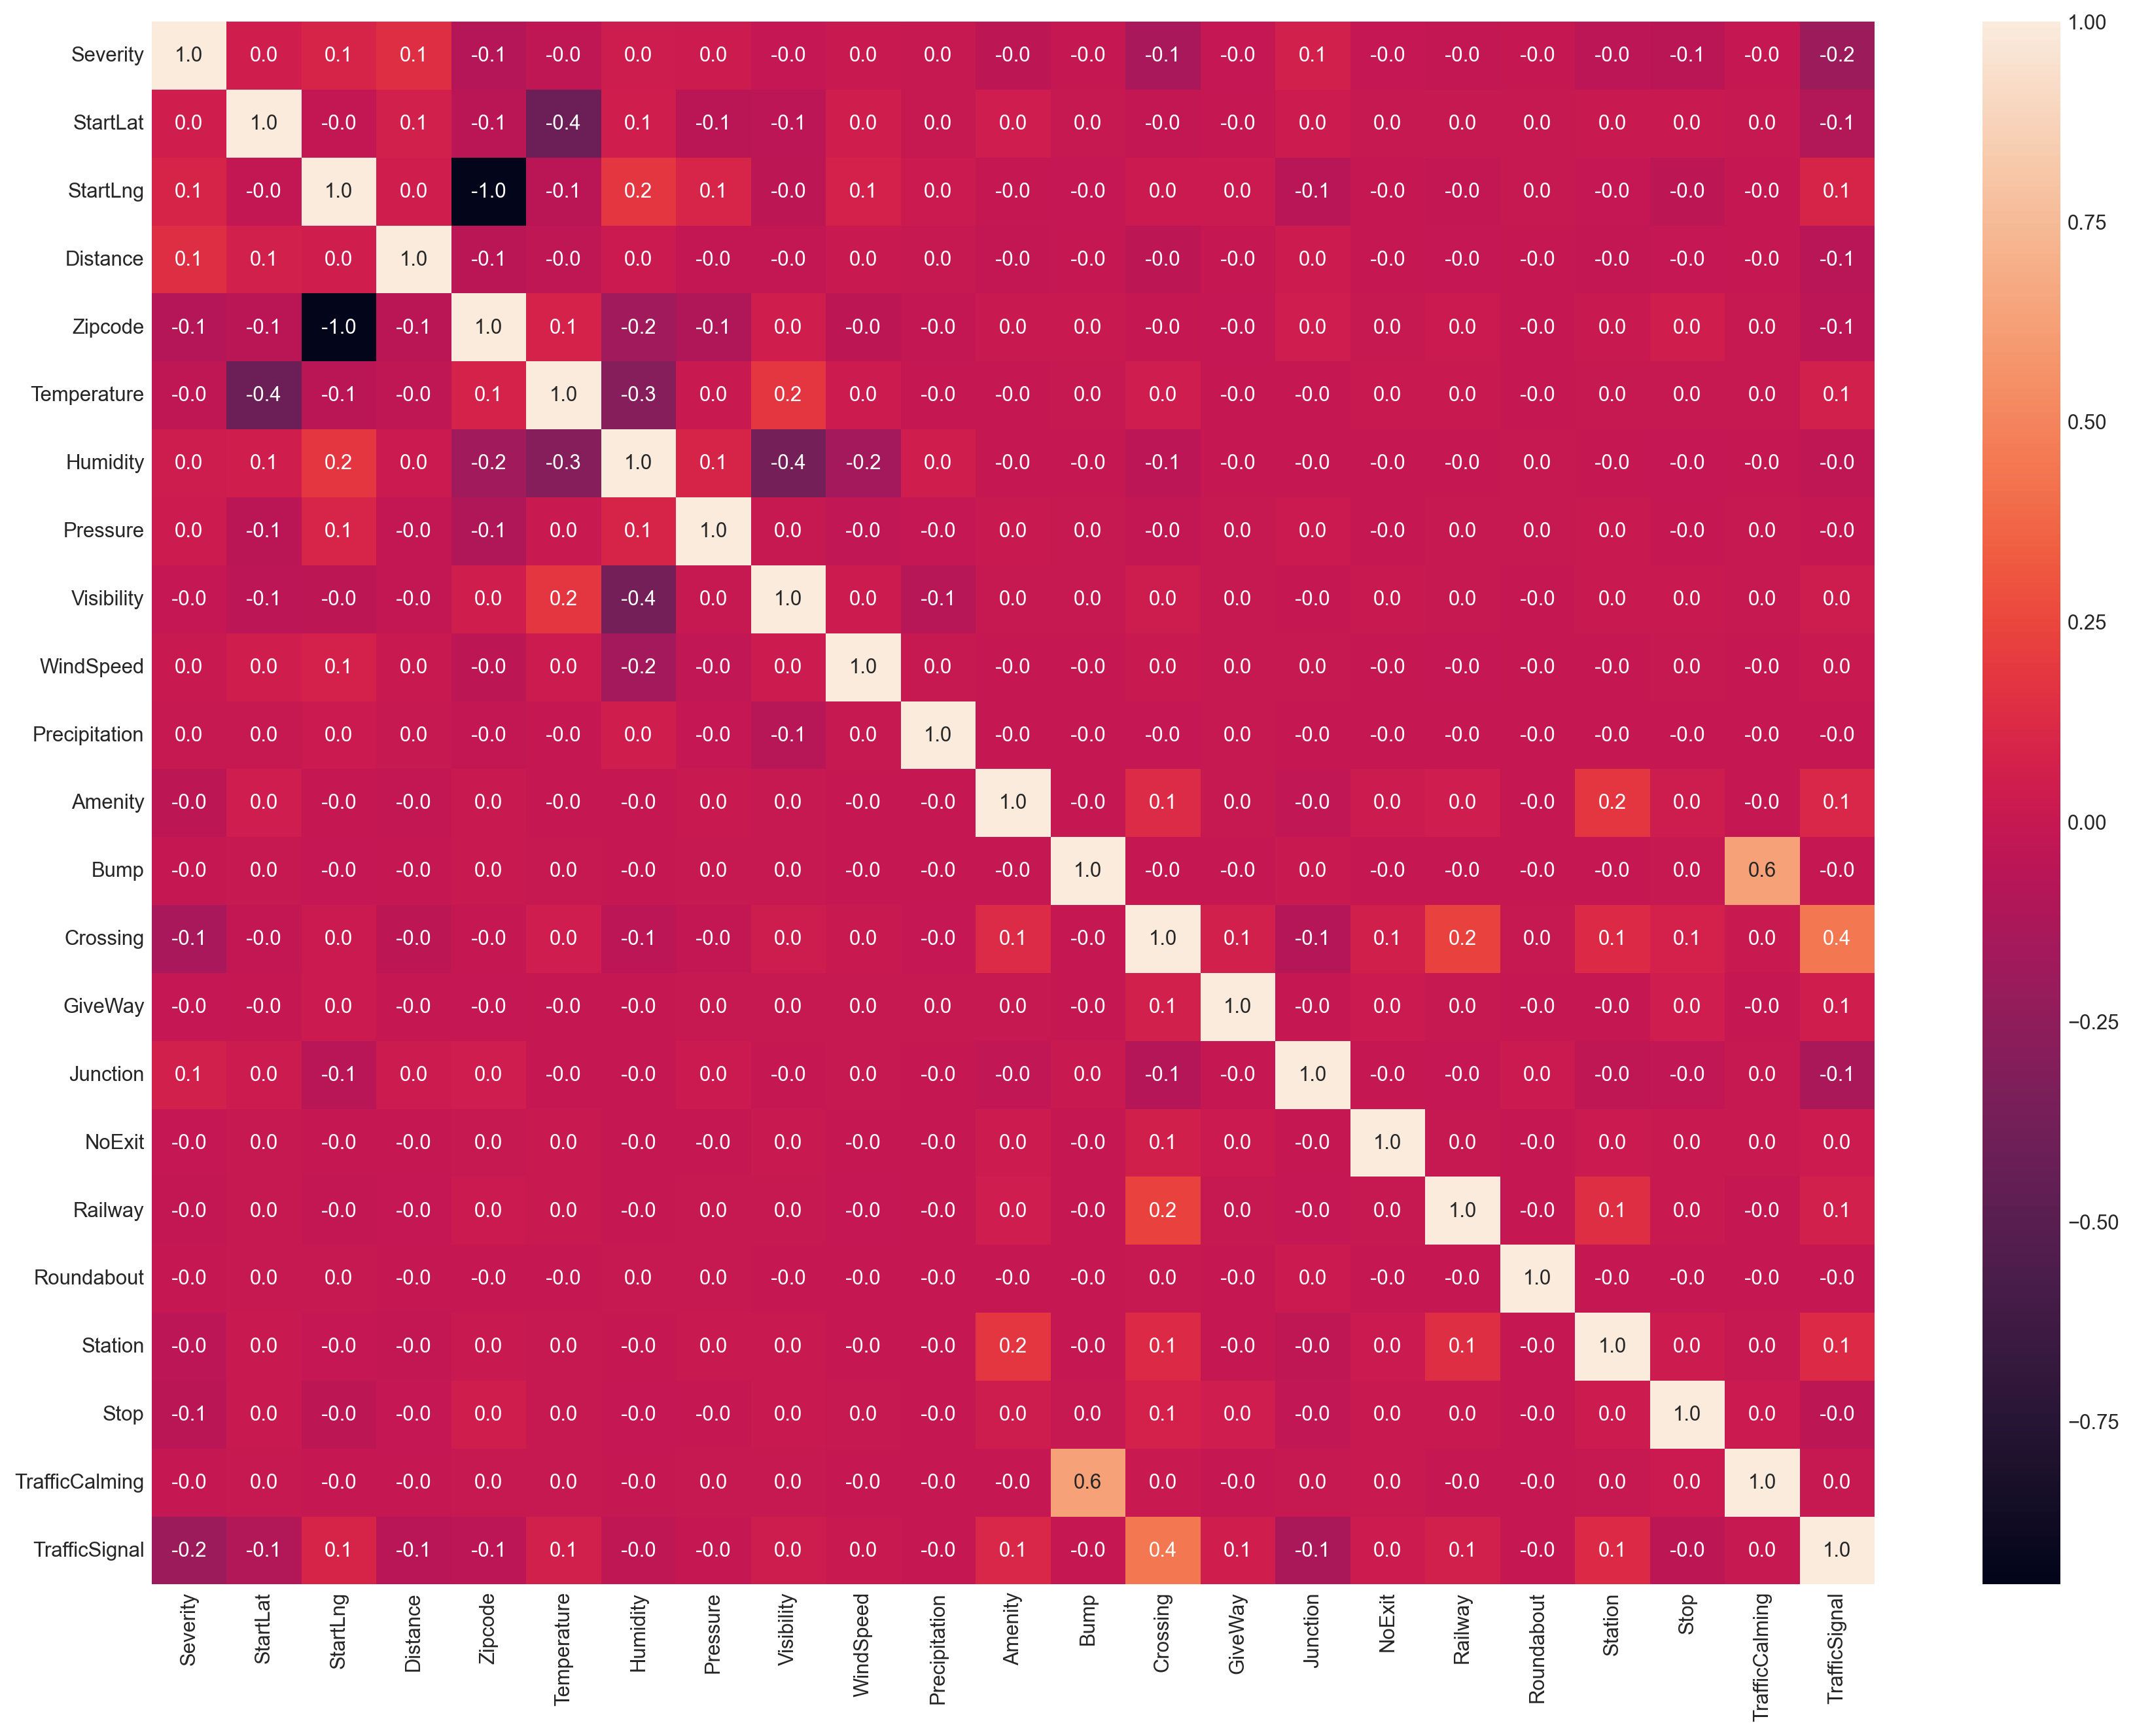

In [6]:
plt.figure(figsize=(16,12),dpi = 223)
sns.heatmap(df.corr(),
           annot=True,
            fmt='.1f'
           )
plt.show()

### Mutual Information

In [7]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
        
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    
    return mi_scores

In [10]:
X = df.copy()
y = X.pop('Severity')

mi_scores = make_mi_scores(X, y)
mi_scores[::4]

StartTime         3.620854
City              0.438466
State             0.035129
Pressure          0.011530
TrafficCalming    0.004496
Junction          0.001072
Roundabout        0.000000
Name: MI Scores, dtype: float64

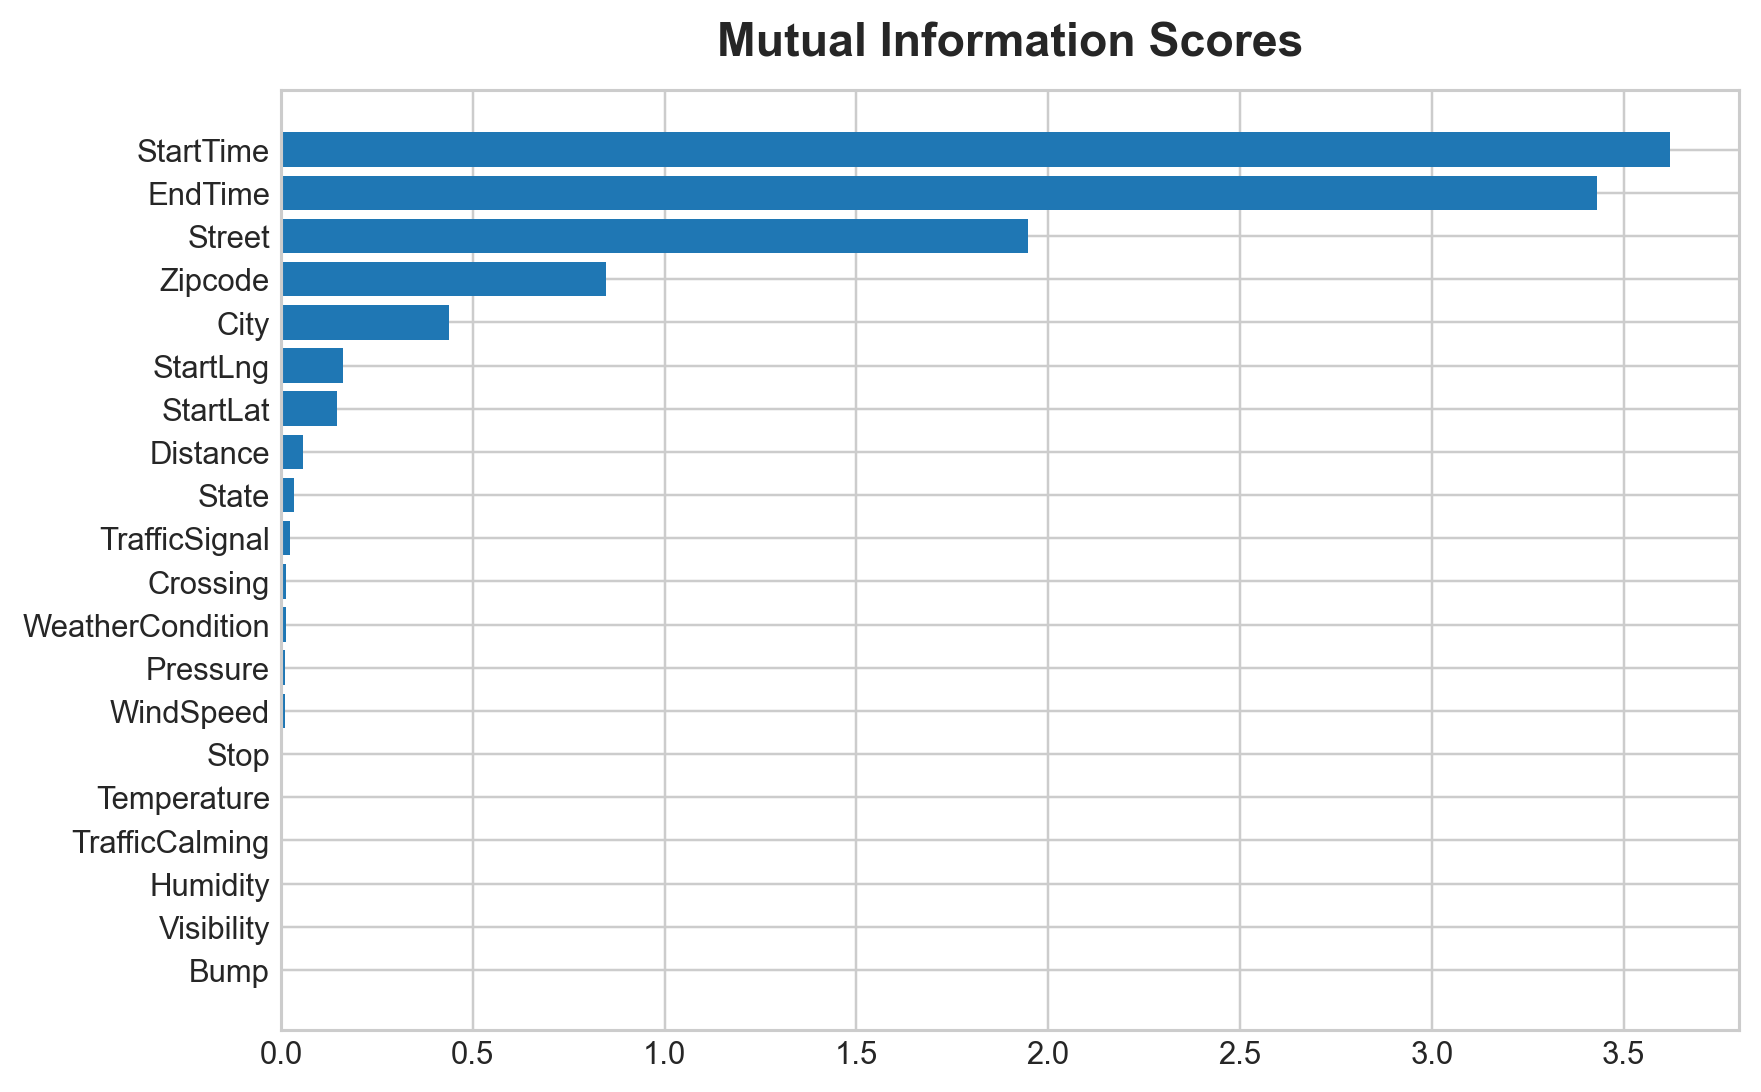

In [11]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

plt.figure(dpi=223, figsize=(8, 5))
plot_mi_scores(mi_scores.head(20))

Data visualization can suggest transformations, often a "reshaping" of a feature through powers or logarithms. The distribution of WindSpeed in US Accidents is highly skewed, for instance. In this case the logarithm is effective at normalizing it:

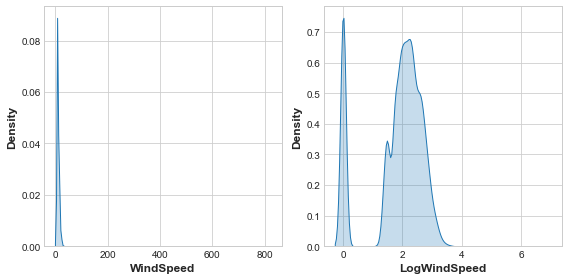

In [14]:
# If the feature has 0.0 values, use np.log1p (log(1+x)) instead of np.log
df["LogWindSpeed"] = df.WindSpeed.apply(np.log1p)

# Plot a comparison
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sns.kdeplot(df.WindSpeed, shade=True, ax=axs[0])
sns.kdeplot(df.LogWindSpeed, shade=True, ax=axs[1])
plt.show()

In [16]:
roadway_features = ["Amenity", "Bump", "Crossing", "GiveWay",
                    "Junction", "NoExit", "Railway", "Roundabout", "Station", "Stop",
                    "TrafficCalming", "TrafficSignal"]
df["RoadwayFeatures"] = df[roadway_features].sum(axis=1)

df[roadway_features + ["RoadwayFeatures"]].sample(10)

,Amenity,Bump,Crossing,GiveWay,Junction,NoExit,Railway,Roundabout,Station,Stop,TrafficCalming,TrafficSignal,RoadwayFeatures
46590,False,False,False,False,False,False,False,False,False,False,False,False,0
53618,False,False,False,False,False,False,False,False,False,False,False,False,0
22739,False,False,False,False,False,False,False,False,False,False,False,False,0
26900,False,False,False,False,False,False,False,False,False,False,False,False,0
44608,False,False,False,False,False,False,False,False,False,False,False,False,0
82056,False,False,False,False,False,False,False,False,False,False,False,False,0
18502,False,False,True,False,False,False,False,False,False,False,False,True,2
28893,False,False,False,False,False,False,False,False,False,False,False,False,0
71150,False,False,False,False,False,False,False,False,False,False,False,False,0
88171,False,False,False,False,False,False,False,False,False,False,False,False,0


In Python, booleans can be added up like integers.
`1` for `True` and `0` for `False`